# Multislice method for STEM 
*From the paper **"A Streaming Multi-GPU Implementation ofImage Simulation Algorithms for Scanning Transmission Electron Microscopy"**   
of Alan Pryor Jr., Colin Ophus and Jianwei Miao*

[Source Paper 1](https://ascimaging.springeropen.com/articles/10.1186/s40679-017-0048-z)
[Source Paper 2](https://ascimaging.springeropen.com/articles/10.1186/s40679-017-0046-1)

### This method consists of two main steps:
> The multislice method is straightforward to implement and is quite efficient for plane-wave or single-probe diffraction simulations.

* The first is **calculation of the projected potentials** from all atoms into a series of 2D slices. 
* Second, the **electron wave is initialized and propagated** through the sample. 

In [1]:
import pyprismatic as pr
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt

from numpy.fft import fft, ifft, fft2, ifft2, fftshift, ifftshift

## 1. Calculation of the Projected Potentials

There we use pyprismatic to do a simulation, then export the ppotentials from the resulting file.

In [2]:
INPUTLINK     = "SI100.XYZ" # link to the .XYZ file with the structure's atoms coordinates
OUTPUTLINK    = "output.h5" # link to the hdf output of the simulation
PARAMETERLINK = "parameters.txt" # link to save the file with the parameters of the simulation

# We initialize the meta object with all the simulations parameters
meta = pr.Metadata(filenameAtoms=INPUTLINK, filenameOutput=OUTPUTLINK)

# Then we edit some of the parameters to save the simulation datas
meta.readParameters(PARAMETERLINK)
# meta.writeParameters(PARAMETERLINK)
meta.savePotentialSlices = 1
meta.saveDPC_CoM  = 1
meta.save2DOutput = 1
meta.save3DOutput = 1
meta.save4DOutput = 0


# We save the acceleration voltage of the electron beams (in V)
acc_ = meta.E0 

# You can call the toString() method of the metadata object to see all it's parameters
# meta.toString() 

# Finally we run the simulation
meta.go()

print("Simulation from the atomic structure ({}) done.".format(INPUTLINK))
print("Output datas saved in {}".format(OUTPUTLINK))
print("Simulation parameters saved in {}".format(PARAMETERLINK))

print("\nSimulation Acceleration Voltage = {} kiloVolt".format(acc_/1000))

Simulation from the atomic structure (SI100.XYZ) done.
Output datas saved in output.h5
Simulation parameters saved in parameters.txt

Simulation Acceleration Voltage = 90.0 kiloVolt


Potentials for: 3 slices
Thickness:      2.0Å
Pixels size:    0.10181249678134918Åx0.10181249678134918Å
Dimension:      160x160 (25600 pixels)
Dimension:      16.28999948501587Åx16.28999948501587Å


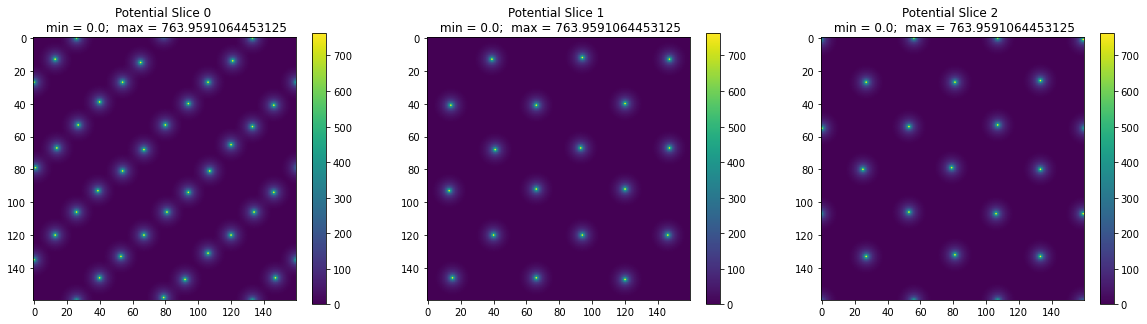

In [3]:
#Recursively find the subfiles and display the structure like the tree function
def recursiveHDF(f, pathstring=''):
    #Test if it is an hdf subfolder
    if hasattr(f, 'keys'):
        
        #List the subkeys of this folder
        subkeys = list(f.keys())
        #Test if it is empty
        if len(subkeys) == 0:
            print(pathstring + '└─── empty' )
        else:
            #Print every subdirectory
            for s in range(len(subkeys)):
                subkey = subkeys[s]
                if(s+1==len(subkeys)):
                    print(pathstring + '└─── ' + subkey)
                    recursiveHDF(f[subkey], pathstring+'     ')
                else:
                    print(pathstring + '├─── ' + subkey) 
                    recursiveHDF(f[subkey], pathstring+'│    ')
    else:
        print(pathstring + '└─── matrix' + str(f.shape))

#Display multiple images on the same line
def displayLine(images, labels):
    n = len(images)
    fig=plt.figure(figsize=(20, 15/n))
    
    for i in range(n):
        fig.add_subplot(1, n, i+1)
        plt.title(labels[i])
        plt.imshow(images[i])
        plt.colorbar()
    plt.show()

# We open the output file for reading with the H5py library (HDF5 file)
f = h5.File(OUTPUTLINK, 'r')

# We use the recursiveHDF function to recursively read the file
# recursiveHDF(f)

# We then read the datas stored from the Projected potential computation
potential = f['4DSTEM_simulation/data/realslices/ppotential/realslice'][()] # computed slices of the atoms potential

# We also get the axis of the datas, X and Y for the 2D plane coordinates position, and Z for the slice position (thickness)
Xaxis = f['4DSTEM_simulation/data/realslices/ppotential/dim1'][()] # potential slice X axis (in Å)
Yaxis = f['4DSTEM_simulation/data/realslices/ppotential/dim2'][()] # potential slice Y axis (in Å)
Zaxis = f['4DSTEM_simulation/data/realslices/ppotential/dim3'][()] # potential slice Z axis (in Å)

# We get the size of the potential slice dimensions (in Px)
Xdim, Ydim, Zdim = potential.shape 

# We get the scale of the pixels for the slice dimensions in the direct space (in Å)
Xscale, Yscale, Zscale = [(Xaxis[1] - Xaxis[0]), (Yaxis[1] - Yaxis[0]), (Zaxis[1] - Zaxis[0])]

print("Potentials for: {} slices".format(Zdim))
print("Thickness:      {}Å".format(Zscale))
print("Pixels size:    {}Åx{}Å".format(Xscale, Yscale))
print("Dimension:      {}x{} ({} pixels)".format(Xdim, Ydim, Xdim*Ydim))
print("Dimension:      {}Åx{}Å".format(Xscale*Ydim, Yscale*Ydim))

# We display the projected potential slices 
displayLine([np.matrix(potential[:,:,i]) for i in range(Zdim)], ["Potential Slice {} \n min = {};  max = {}".format(i, np.min(potential[:,:,i]), np.max(potential[:,:,i])) for i in range(Zdim)])

# We close the .h5 file to avoid conflits
f.flush()
f.close()


## 2. Initialisation and propagation of the electron waves throug the sample


In [4]:
m0 = 9.109383e-31 # Electron mass (in kg)
e_ = 1.602177e-19 # Elementary charge (in coulomb)
c_ = 299792458 # Light speed (in m/s)
h_ = 6.62607e-34 # Planck constant in (m2 kg/s)

print("beam acceleration = {} kV".format(acc_/1000))

# We compute the electron beam energy with the electrong beam voltage
E0 = m0 * c_ * c_ 
E1 = e_ * acc_  

# We compute the Wave length (in Å)
lambda_ = h_ * c_/ np.sqrt(2*E0*E1 + E1*E1) * 1e10
print("lambda_ = {}Å".format(lambda_))

# Beam interaction (in V-1 A-1)
# I prefer to write sigma_ like this because, the unit of sigma are then straightforward. 
sigma_ = 2.*np.pi/lambda_/acc_ * (E0+E1)/(2*E0+E1)
print("sigma_ = {}V-1 A-1".format(sigma_))
   
# We initialize the waves functions as a matrix of the same shape as the slices
# https://en.wikipedia.org/wiki/Wave_function
electronWaves = np.zeros(shape=(Xdim, Ydim, Zdim), dtype=np.complex) 

### 2.1 First the complex electron wave $\psi$ representing the initial converged probe is defined, typically as an Airy disk function [c]. This probe is positioned at the desired location on the sample surface in realspace [d].

<img src="figure1.png" />

beam acceleration = 90.0 kV
lambda_ = 0.039191605264512826Å
sigma_ = 0.0009627511851912703V-1 A-1
Reciprocal pixel size = 0.06138735614570376Å-1 x 0.06138735614570376Å-1 x 0.16666666666666666Å-1
Direct_pixel_size = 0.10181249678134918Å x 0.10181249678134918Å x 2.0Å)

Radius in pixel = 106.05593229234358 x 106.05593229234358
Radius in mrad = 10 x 10
Radius in Å-1 = 0.25515668298115846 x 0.25515668298115846

max_probe = (0.04718646522044221+0j)
0.9999999999999999 norm = 0.047186465220442175


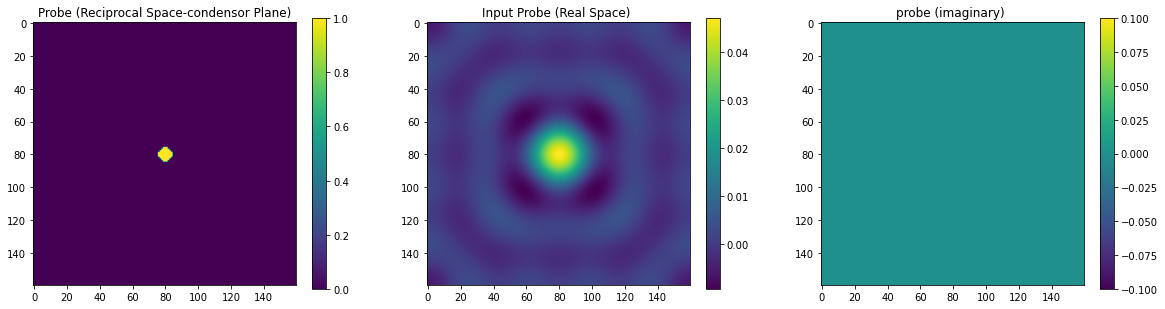

In [5]:
# We compute the input probe in the condenser aperture plane
# rec_inputProbe is the input wave function in the condensor aperture plane. Radius is linked to the condensor aperture radius
# TAKE CARE OF THE UNITS : indeed there is a 'demagnification' between the condensor aperture and the 'sample' conjugated plane
# Without this demagnification radius, to go from the condensor aperture plane to the input plane of the sample, one should apply 
# an inverse Fourier Transform 
# For the units, the easiest is to work with angles (radian is in fact no physical units !) and take for reference the angles 
# without demagnification i.e. a demagnification equal to 1, i.e. use the sample (direct space) and its reciprocal space (
#  calibrated in radian using the relationship between reciprocal vectors and angles ( lambda g = alpha )

# Radius is linked to the condensor aperture radius
HradiusMrad, KradiusMrad = [10, 10] # in mrad 

# TAKE CARE OF THE UNITS : indeed there is a 'demagnification' between the condensor aperture and the 'sample' conjugated plane
# Without this demagnification radius, to go from the condensor aperture plane to the input plane of the sample,
# one should apply an inverse Fourier Transform
# IN FACT THE EASIEST SOLUTION FOR THE UNIT ISSUE IS TO USE THE pixel_size of the direct space !!!
#    a) from the dir_pixel_size compute the rec_pixel_size    b) knowing the convergence angle (in fact this is the conjugated aperture condensor size in the reciprocal space of the sample )
#   compute the radius in pixel 
# JLR a oublié les conventions de prismatic et trouve plus rapide pour l'instant de redéfinir les siennes
# MAEL : --> cherche à uniformiser les 2 en écrivant dir_pixel_size = prismatic_value

Hscale, Kscale, Lscale = [1/(Xdim * Xscale), 1/(Ydim * Yscale), 1/(Zdim * Zscale)] # in Angstrom-1

print("Reciprocal pixel size = {}Å-1 x {}Å-1 x {}Å-1".format(Hscale, Kscale, Lscale))
print("Direct_pixel_size = {}Å x {}Å x {}Å)\n".format(Xscale, Yscale, Zscale))

HscaleRad, KscaleRad    = [lambda_ * Hscale, lambda_ * Kscale]  # the reciprocal pixel size in radian
Hradius, Kradius = [HradiusMrad * 1e-3/lambda_, KradiusMrad * 1e-3/lambda_]
HradiusPix, KradiusPix = [Hradius / HscaleRad, Kradius / KscaleRad]

print("Radius in pixel = {} x {}".format(HradiusPix, KradiusPix))
print("Radius in mrad = {} x {}".format(HradiusMrad, KradiusMrad))
print("Radius in Å-1 = {} x {}".format(Hradius, Kradius))

#  JLR prefers to use meshgrid as it is done in several programs working with 2D images
#  xx, yy will be 2D arrays representing the column and row indexes of the images, the index origin being at the center of the image
#  these arrays can then be used both in real and reciprocal spaces and pixel size values have to be used to have the correct units 
# next line is a typical short python equality. JLR is not sure that this one line is better than 2 lines of codes
#  it should be better to define x, y as signed integer
x, y    = (np.arange(0, Xdim, dtype="float32") - np.floor(Xdim/2)), (np.arange(0, Ydim, dtype="float32") - np.floor(Ydim/2))
xx, yy  = np.meshgrid(x,y)
fx, fy  = xx*Hscale, yy*Hscale

#aperture_ = fx**2 + fy**2 < Hradius**2 # condensor aperture
aperture_ = (fx/Hradius)**2 + (fy/Kradius)**2 < 1 # condensor aperture
rec_inputProbe = aperture_ + 0j

# apparently when doing an FFT in numpy, the origin should be be at the top,left corner and not at the center of the image
# so we have to apply an ifftshift or fftshift (JLR does not see the difference ? ) to correct for that. 
inputProbe  = fftshift(ifft2(ifftshift(rec_inputProbe)))
norm        = np.linalg.norm(inputProbe)
inputProbe /= norm

# il serait egalement bien de normaliser la fonction d'onde (normalement elle devrait aller à 0 en bord de boite sinon le nombre de pixel est pas suffisant ...)
print("\nmax_probe = {}\n{} norm = {}".format(np.max(inputProbe), np.linalg.norm(inputProbe), norm)) 

displayLine([np.real(rec_inputProbe),  np.real(inputProbe), np.imag(inputProbe)], 
            ["Probe (Reciprocal Space-condensor Plane)", "Input Probe (Real Space) ", "probe (imaginary) "])


### Espace direct et réciproque ?
1 | 2
  ------------- | -------------
<img src="reciproque.png"/>|<img src="reciproque.gif" />

[Source vidéo](https://www.youtube.com/watch?v=KOfJhj_IF0Y)
   
[Fourier Transform course](https://www.youtube.com/watch?v=spUNpyF58BY)   
[Fourier transfrom and Heisenberg incertitude notions for quantum physic](https://www.youtube.com/watch?v=MBnnXbOM5S4)   
[Light quantum mechanics](https://www.youtube.com/watch?v=MzRCDLre1b4)  
[Quantum particle analogy](https://www.youtube.com/watch?v=WIyTZDHuarQ)  
[La transformation de fourier et ses applications en physique](https://www.youtube.com/watch?v=4XCSoFLFLNE)  
   
   > "En diffraction, le réseau réciproque apparaît comme le transformé de Fourier de l'espace réel" [Explications réciproque cristallo](http://ressources.univ-lemans.fr/AccesLibre/UM/Pedago/physique/02/cristallo/reciproque.html)


[FFT vidéo](https://www.youtube.com/watch?v=IUaqeoMK5y4)  
[Espace réciproque](https://fr.wikipedia.org/wiki/Espace_r%C3%A9ciproque)  
[Réseau réciproque](https://fr.wikipedia.org/wiki/R%C3%A9seau_r%C3%A9ciproque)  
[Direct and Reciprocal Lattice Visualizer 3D](http://calistry.org/viz/direct-and-reciprocal-lattice-visualizer)  

### 2.2 Next, this probe is propagated through the sample’s potential slices by alternating two steps

#### 2.2.1 The first step is a transmission through a given potential slice $V^{2D}_{p}$ over the realspace coordinates $\overrightarrow{r}$

$$\psi_{p+1}(\overrightarrow{r}) = \psi_{p}(\overrightarrow{r}) \exp [ i \sigma V^{2D}_{p} (\overrightarrow{r}) ]$$

where $\sigma$ is the beam-sample interaction constant, and $V^{2D}_{p} (\overrightarrow{r})$ is the 2D electrostatic potential of all atoms inside slice $p$, integrated over the slice along the beam direction from the 3D potential.

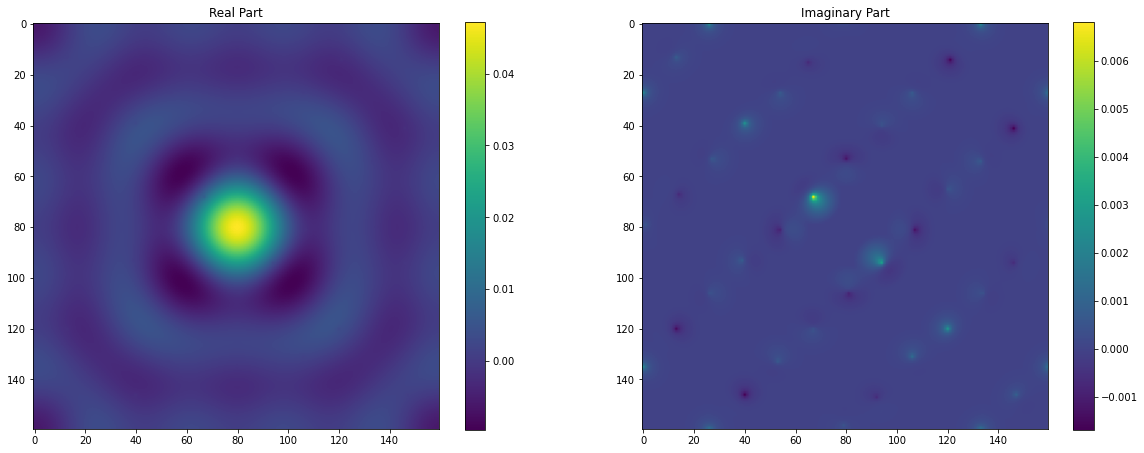

In [6]:
# Interaction with potential
# https://fr.wikipedia.org/wiki/Espace_réciproque
# https://fr.wikipedia.org/wiki/Réseau_réciproque

# complex(0,1) = 1j = 1.0j

# Transmission of the input probe in the slice with the potentials
def transmission(inputProbes, projectedPotential):
    return inputProbes*np.exp(1j*sigma_*projectedPotential)
    
electronWaves[:,:,0] = transmission(inputProbe, potential[:,:,0])

displayLine([electronWaves[:,:,0].real, electronWaves[:,:,0].imag], 
            ["Real Part"              , "Imaginary Part"])

#### 2.2.2 Next, the electron wave is propagated over the distance $t$ to the next sample potential slice, which is done in Fourier space over the Fourier coordinates $\overrightarrow{q}$

$$\Psi_{p+1}(\overrightarrow{q}) = \Psi_{p}(\overrightarrow{q}) exp( −i \pi \lambda {\mid \overrightarrow{q} \mid}^2 t )$$

where $\lambda$ is the electron wavelength, $\Psi(q)=F \{ \psi(r)\}$ is the Fourier transform of $\psi(\overrightarrow{r})$, $\overrightarrow{q} =(q_{x}, q_{y})$ is the 2D coordinate vector for Fourier space, and the subscript $p$ refers to the slice index.

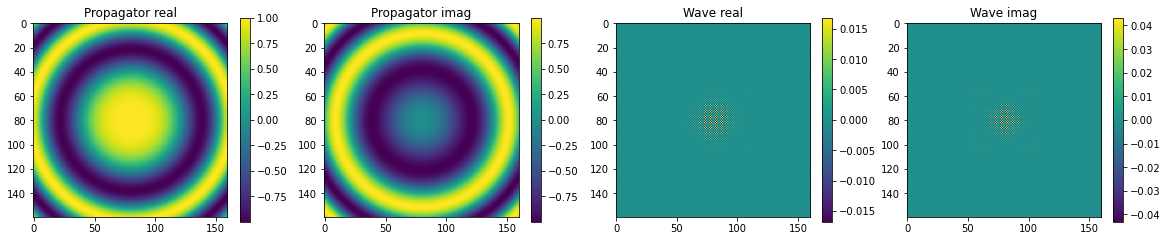

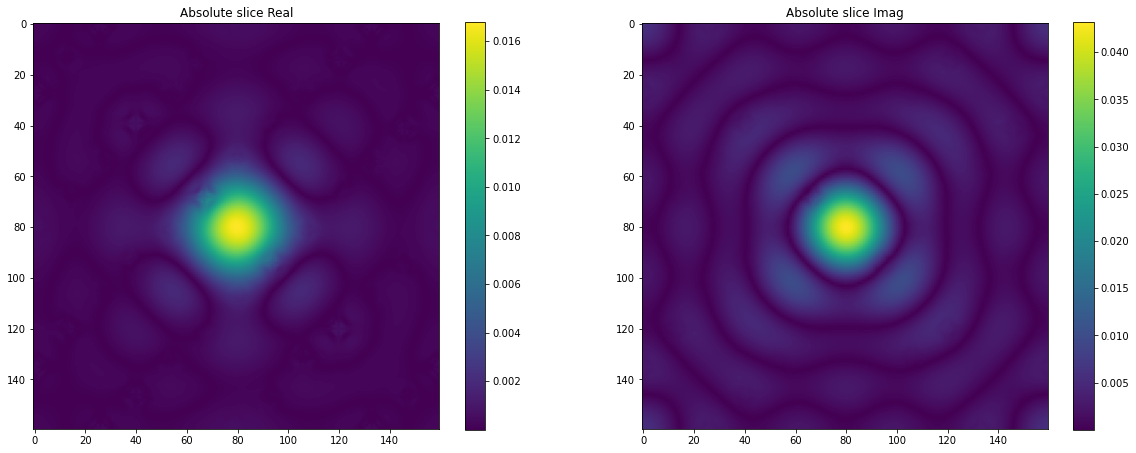

In [7]:
# Propagation in vacuum over the distance t_
# wave_in is the initial wave funtion expressed in the direct space  
# It seems better to store the wave function only in the direct space 
# (apparently prismatic has 2 arrays for the wavefunctions:
# one in the direct space and one in the reciprocal space (to check) )

propagator = np.exp(-1j*np.pi*lambda_*(fx**2+fy**2)*Zscale)

def propagate(wave_in):
    wave_out   = ifft2(fftshift(fft2(wave_in) * propagator) ) 
    displayLine([propagator.real, propagator.imag, wave_out.real, wave_out.imag], 
            ["Propagator real", "Propagator imag", "Wave real","Wave imag"])
    return wave_out

electronWaves[:,:,1] = propagate(electronWaves[:,:,0])

displayLine([np.abs(electronWaves[:,:,1].real), np.abs(electronWaves[:,:,1].imag)], 
            ["Absolute slice Real"                 , "Absolute slice Imag"])

#### 2.2.3 These steps are alternated until the electron probe has been propagated through the entire sample.

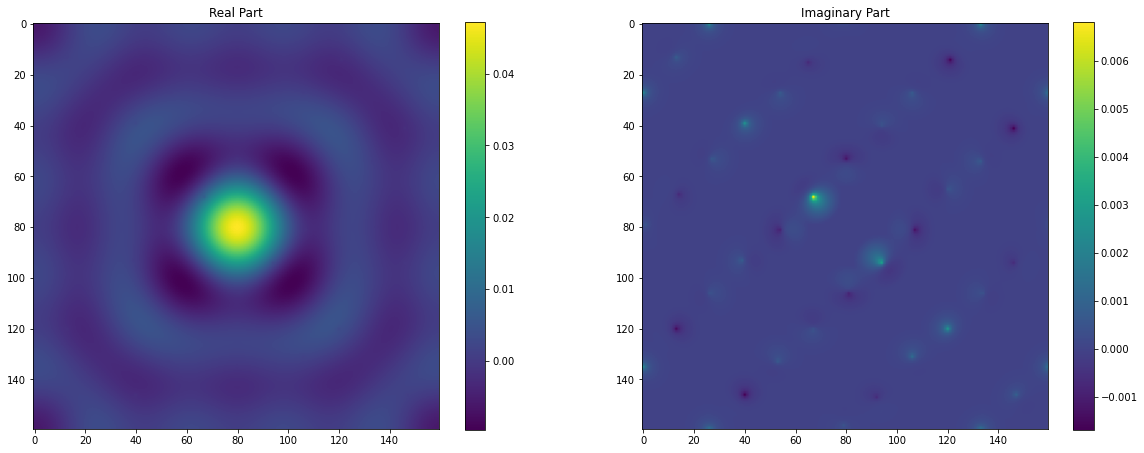

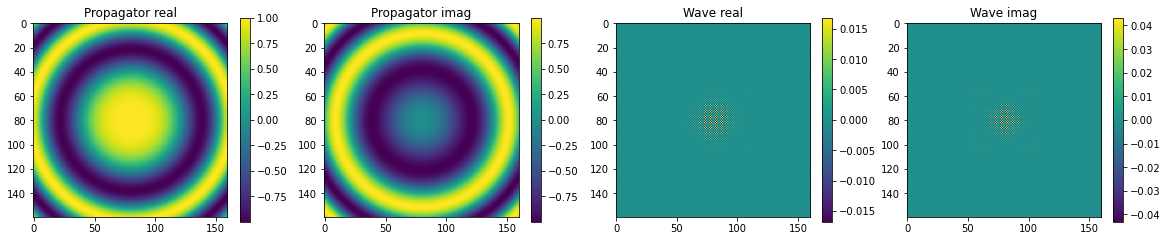

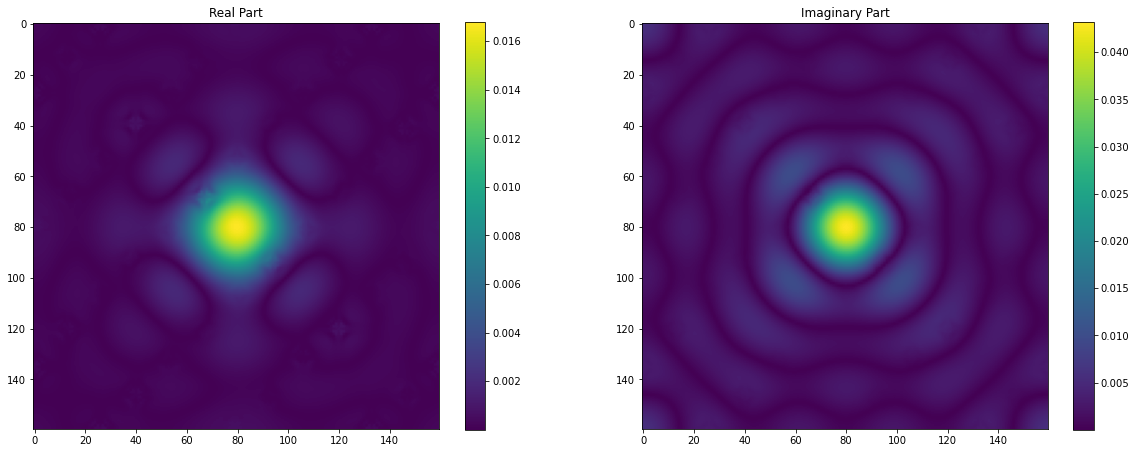

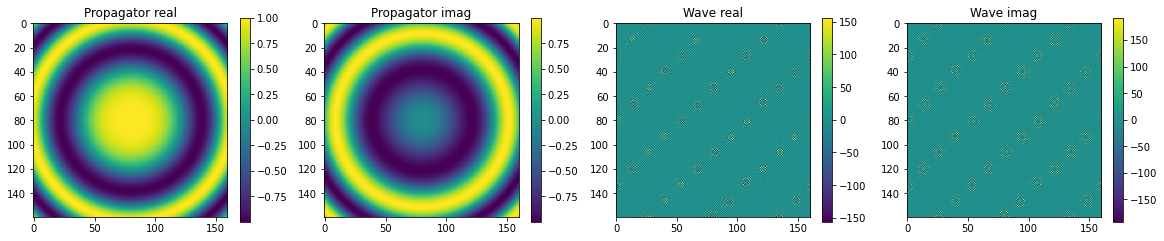

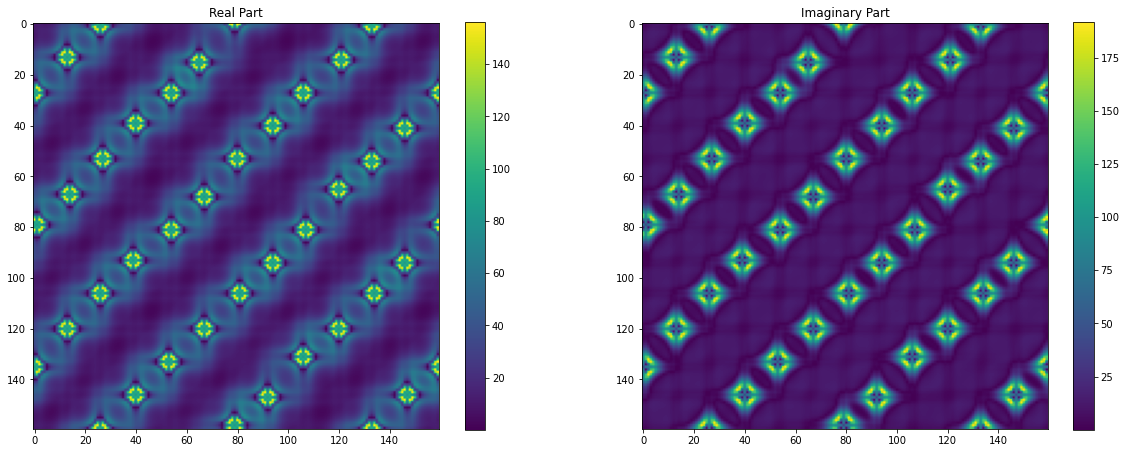

In [8]:
# Recompute all
electronWaves = np.zeros(shape=(Xdim, Ydim, Zdim), dtype=np.complex) 

electronWaves[:,:,0] = transmission(inputProbe, potential[:,:,0])
displayLine([electronWaves[:,:,0].real, electronWaves[:,:,0].imag], 
            ["Real Part", "Imaginary Part"])

for i in range(1, Zdim):
    electronWaves[:,:,i] = propagate(electronWaves[:,:,i-1])
    displayLine([np.abs(electronWaves[:,:,i].real), np.abs(electronWaves[:,:,i].imag)], 
                ["Real Part", "Imaginary Part"])
    electronWaves[:,:,i] = transmission(potential[:,:,i-1], potential[:,:,i])
    

## 3. Next, the simulated output is computed
which is typically a subset of the probe’s intensity summed in Fourier space as shown in Fig. 1e. The steps given in Figs. 1c-e are repeated for the desired probe positions, typically a 2D grid. The simulation result can be a single virtual detector, an array of annular ring virtual detectors or the entire probe diffraction pattern for each probe location, giving a 2D, 3D or 4D output respectively. 

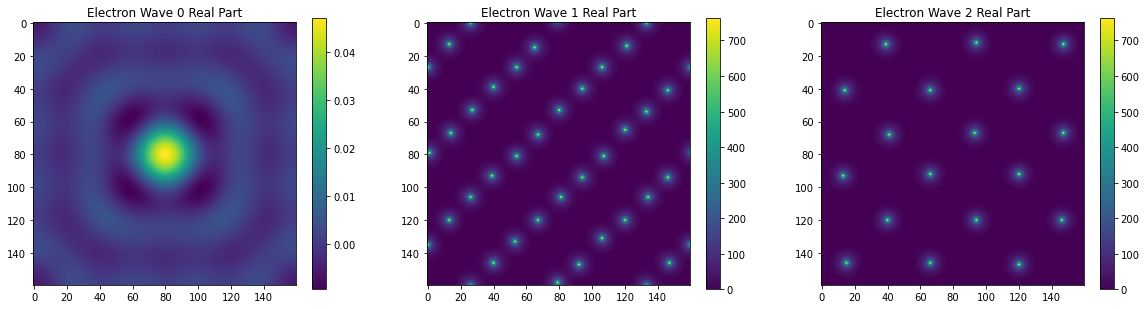

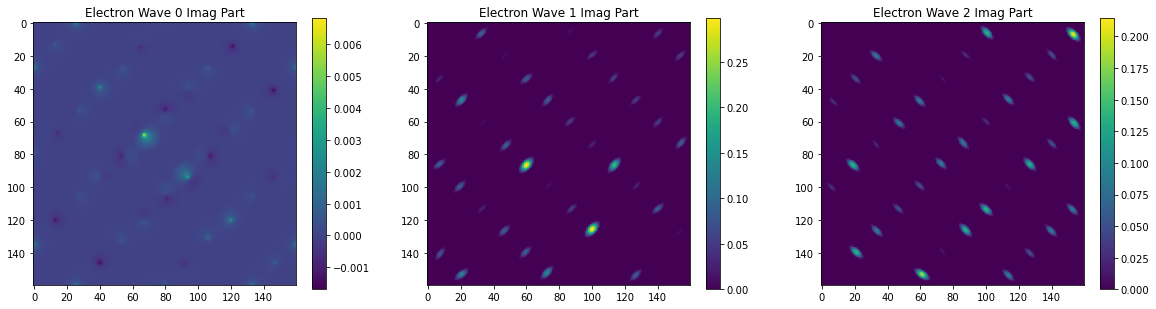

In [9]:
displayLine([electronWaves[:,:,i].real for i in range(Zdim)], ["Electron Wave {} Real Part".format(i) for i in range(Zdim)])
displayLine([electronWaves[:,:,i].imag for i in range(Zdim)], ["Electron Wave {} Imag Part".format(i) for i in range(Zdim)])